# 数据集介绍
&#8195;&#8195;到现在为止，我们收集的数据中包含YouTube频道的id和名字、SocialBlade的排名和评分、上传视频数量、订阅量、视频总播放量、视频种类、创建时间、按订阅量的排名、按总播放量的排名、在所在国家的排名、在同类型频道中的排名、最近30天的订阅者数量、最近30天的视频播放量、最高和最低的月收入年收入估计、频道所在国家及这些国家的失业率、人口总数、人均GDP。未来可能会根据想要探究的问题收集更多数据。

&#8195;&#8195;具体的收集方式是这样的。SocialBlade 是一个领先的 YouTube 数据分析工具，提供详细的频道统计和排名信息，帮助用户深入了解频道的表现和趋势。我们在SocialBlade网站上首先收集了关于近12个国家的youtube榜单，每个榜单上包含100个YouTube channel的信息。然后再根据这个名单，在SocialBlade网站上利用批量操作脚本保存了相关网页的可打印信息，最后在本地进行脚本操作，提取相关数据制作相应表格。有关相应国家的失业率、人口总数、人均GDP等数据收集自[worldbank](https://data.worldbank.org/),这个网站提供了良好的数据库接口，根据相关数据集的CC-BY 4.0要求，我们选取的数据来源于Jobs、Population estimates and projections、World Development Indicators，我们在制作数据集时并没有对原始数据进行转换，只是从中提取了相应的国家和属性。

# 数据分析
&#8195;&#8195;首先先载入之后分析时所需要的包

In [1]:
#import some package
#data process
import numpy as np 
import pandas as pd 
from sklearn.linear_model import LinearRegression
#plot
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import os

&#8195;&#8195;然后从相应路径读取数据集，由于数据集存在多个版本，建议单独设置一个目录存放。

In [2]:
df = pd.read_csv("youtube_data/youtube_data_v2_5.csv", encoding="utf-8")
df_cleaned = df.dropna(how='any') #清掉存在nan数据的行

In [3]:
print(f'原始数据一共有{df.shape[0]}行，{df.shape[1]}列')
print(f'去掉含有NAN数据的行后，剩余{df_cleaned.shape[0]}行')
print(f'Category列一共有{sum(df["Category"].isna())}个NAN')
print(f'Video Views for the last 30 days列一共有{sum(df["Video Views for the last 30 days"].isna())}个NAN')

原始数据一共有1189行，26列
去掉含有NAN数据的行后，剩余781行
Category列一共有361个NAN
Video Views for the last 30 days列一共有4个NAN


&#8195;&#8195;经过一些数据分析后，我们可以看见原始数据在Category列有较多的NAN，这是因为这个Category属性是Social Blade数据源给出的，他们根据相应channel最近10个视频的tag得出了一个channel的Category，这样的话，对于视频种类混乱或者是tag打的不好的channel，我们就没能得到他们的一个Category估计。

&#8195;&#8195;我们首先考虑分析订阅人数、总播放量、近30天播放量与类型的关系，将'近30天播放量'作为散点的大小，'Category'作为颜色，制作一个这四个属性的散点图，如下图所示。

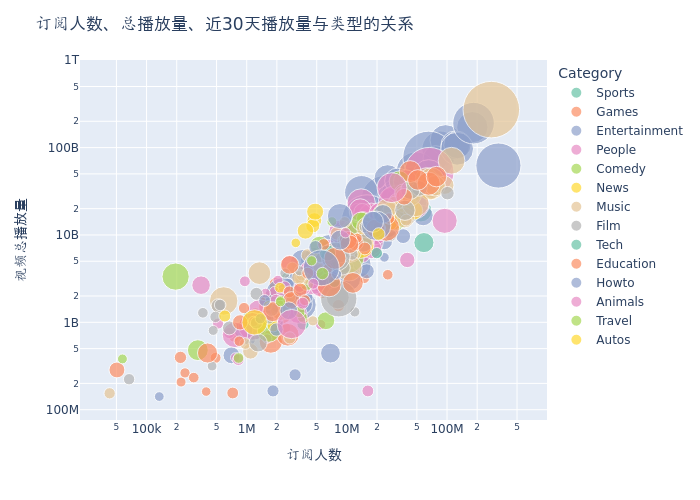

In [4]:
#figure1
df_fig1 = df_cleaned[df_cleaned['Video Views for the last 30 days'] > 1e8]  # 筛掉过于小的点
fig1 = px.scatter(df_fig1, x='Subs', y='Video Views', size='Video Views for the last 30 days',
                  color='Category', hover_name='Channel name', hover_data=['Nation'], size_max=40,
                  labels={'Subs': '订阅人数', 'Video Views': '视频总播放量'},
                  color_discrete_sequence=px.colors.qualitative.Set2)
fig1.update_layout(title_text='订阅人数、总播放量、近30天播放量与类型的关系',xaxis_type='log',yaxis_type='log')
#fig1.show()#一些notebook服务器不支持动态
# 保存为静态图像并展示
fig1.write_image("./figs/fig1.png")
Image(filename="./figs/fig1.png")

&#8195;&#8195;可以看出近30天播放量大于一亿的频道中最火的类型为音乐、娱乐、个人博客、教育。例如，右侧最大的点是印度的音乐频道 T-Series，该频道在 Social Blade 上排名第2，无疑是顶流频道之一。而排名第1的频道HiFunnie来自美国，它属于娱乐范畴。个人频道中最热门的频道来自韩国，我找相关视频看了一下，感觉这类型还是以编排一些生活中的小剧场为主，以脑洞和新颖作为卖点。

&#8195;&#8195;同时，总播放量和订阅人数在图中看起来大概成正比，但不管订阅人数和总播放量的大小，近30天的播放量都有大有小。我们知道，如果两个变量在一个log变换下的图中呈现线性关系，那他们之间应该存在一个幂方关系，我们试着对此建模。

幂律关系: Video Views = 3589.57 * (Subs)^0.89


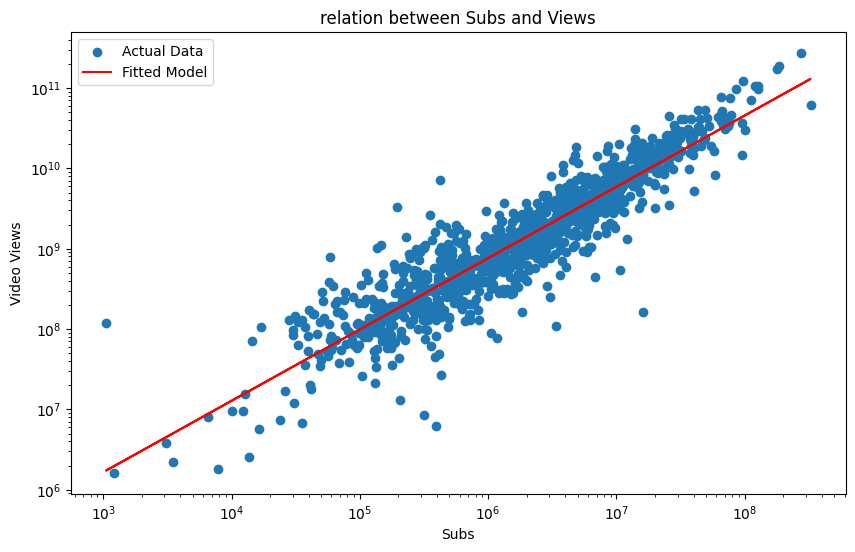

In [5]:
df_filtered = df[(df['Subs'] > 0) & (df['Video Views'] > 0)].copy()
df_log = np.log(df_filtered[['Video Views', 'Subs']])
X = df_log['Subs'].values.reshape(-1, 1)
y = df_log['Video Views'].values.reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)

# 获取回归系数
a = np.exp(model.intercept_[0])
b = model.coef_[0][0]

# 打印回归结果
print(f"幂律关系: Video Views = {a:.2f} * (Subs)^{b:.2f}")

# 将回归结果转换回原始尺度
df_filtered['Predicted Video Views'] = a * (df_filtered['Subs'] ** b)

# 可视化结果
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered['Subs'], df_filtered['Video Views'], label='Actual Data')
plt.plot(df_filtered['Subs'], df_filtered['Predicted Video Views'], color='red', label='Fitted Model')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Subs')
plt.ylabel('Video Views')
plt.title('relation between Subs and Views')
plt.legend()
plt.show()

&#8195;&#8195;然后我们分析了订阅人数、总播放量、近30天播放量与频道所在国家的关系，各国近30天播放量较多的频道的数量和各国经济情况，如下图所示。

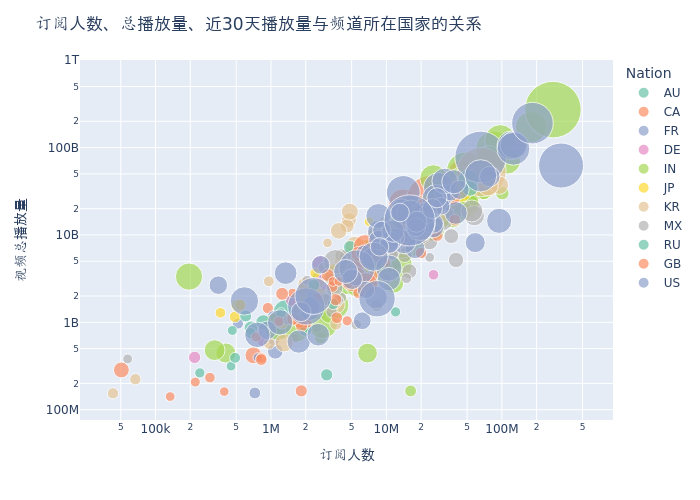

In [6]:
#figure2
df_fig2 = df_cleaned[df_cleaned['Video Views for the last 30 days']>1e8]  # 筛掉过于小的点
fig2 = px.scatter(df_fig2, x='Subs', y='Video Views', size='Video Views for the last 30 days',
                  color='Nation', hover_name='Channel name', hover_data=['Category'], size_max=40,
                  labels={'Subs': '订阅人数', 'Video Views': '视频总播放量'},
                  color_discrete_sequence=px.colors.qualitative.Set2)
fig2.update_layout(title_text='订阅人数、总播放量、近30天播放量与频道所在国家的关系', xaxis_type='log', yaxis_type='log')
# 保存为静态图像并展示
fig2.write_image("./figs/fig2.png")
Image(filename="./figs/fig2.png")

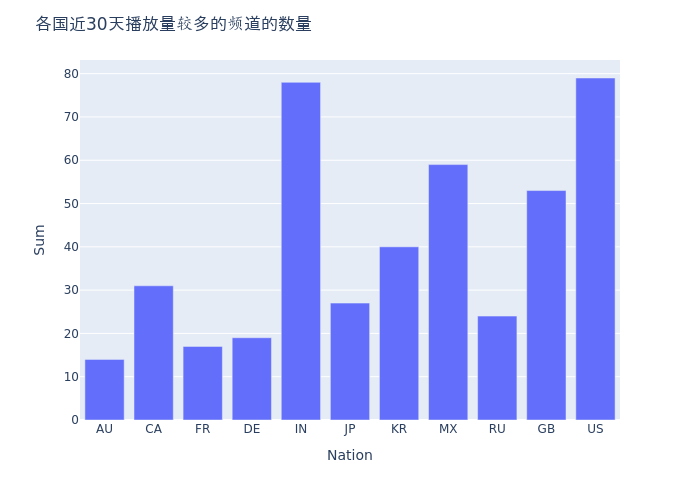

In [7]:
#figure3
sum_channel = {'Nation':[], 'Sum':[]}
for nation in df_fig2['Nation'].drop_duplicates():
    sum_channel['Nation'].append(nation)
    sum_channel['Sum'].append(len(df_fig2[df_fig2['Nation']==nation]))  # 国籍为nation的有多少
sum_channel = pd.DataFrame.from_dict(sum_channel)
# print(sum_channel)
fig3 = px.bar(sum_channel,x="Nation",y="Sum")
fig3.update_layout(title_text='各国近30天播放量较多的频道的数量')
# 保存为静态图像并展示
fig3.write_image("./figs/fig3.png")
Image(filename="./figs/fig3.png")

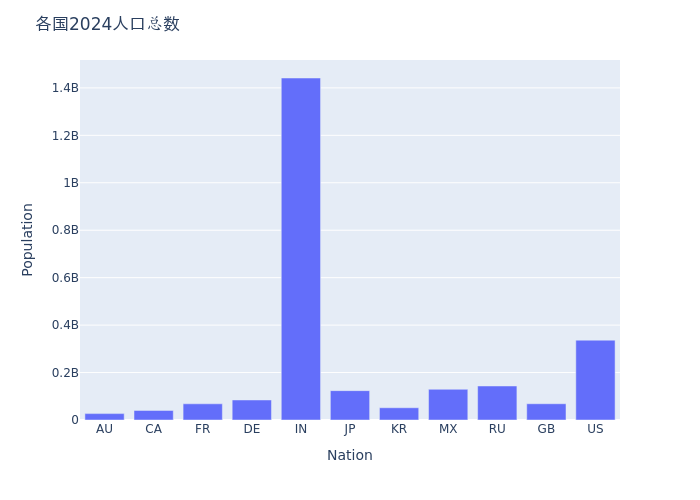

In [8]:
#figure4
nation_population = {'Nation':[], 'Population':[]}
for nation in df_fig2['Nation'].drop_duplicates():
    nation_population['Nation'].append(nation)
    nation_population['Population'].append(df_fig2[df_fig2['Nation']==nation]['2024 Population, total'].iloc[0])  # 总人数
nation_population = pd.DataFrame.from_dict(nation_population)
fig4 = px.bar(nation_population,x="Nation",y="Population")
fig4.update_layout(title_text='各国2024人口总数')
# 保存为静态图像并展示
fig4.write_image("./figs/fig4.png")
Image(filename="./figs/fig4.png")

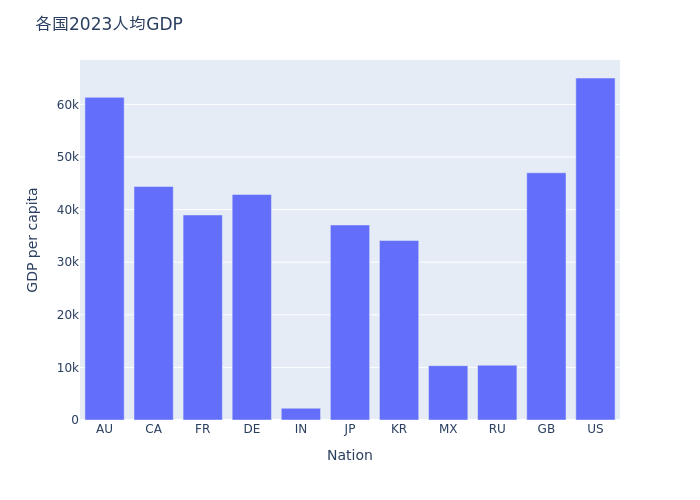

In [9]:
#figure5
nation_gdp = {'Nation':[], 'GDP per capita':[]}
for nation in df_fig2['Nation'].drop_duplicates():
    nation_gdp['Nation'].append(nation)
    nation_gdp['GDP per capita'].append(df_fig2[df_fig2['Nation']==nation]['2023 GDP per capita'].iloc[0])  # 人均生产总值
nation_gdp = pd.DataFrame.from_dict(nation_gdp)
fig5 = px.bar(nation_gdp,x="Nation",y="GDP per capita")
fig5.update_layout(title_text='各国2023人均GDP')
# 保存为静态图像并展示
fig5.write_image("./figs/fig5.png")
Image(filename="./figs/fig5.png")

&#8195;&#8195;从上面的统计分析图表中，可以看出在近30天播放量大于一亿的频道中，最火的频道集中于美国和印度，而且这两国的近30天播放量较大的频道的数目也是最多的。同时观察到，印度人口最多而人均GDP最低，美国人口数量第二而人均GDP最高，在两种情况下，两国都存在顶流youtube频道，基于这个有趣的情况，可以进一步探索国家经济状况是否对youtube频道活跃度有关，是否youtube活跃度和国家人口数量有一个直接关联等问题。

# 任务分析
&#8195;&#8195;根据以上的分析，我们暂定想要探索的任务为不同国家经济状况对youtube频道注册的影响，并发掘人们最感兴趣的是什么方面的频道。